# From Merged Raw Data to Project Data

- From merged dataset to project specific dataset
- Here filtering by cruise name
- Export and Save Files
- pull in collapseNoMismatch processed data (Dada2 program)
- pull in latest Metadata Sheets from /MBON
- For CN19S, remove final drift samples from ESP samples

In [1]:
# Libraries to not include:
drop_libs = ['AC', 'AD', 'AH']

### Imports

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob

#For illustrator import:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

### Functions

In [3]:
# Dada2 Banzai Output Functions
levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

def make_metadata(infile):
    df = pd.read_csv(infile)
    df.set_index('sample_name', inplace=True)
    return df

#Raw Read Numbers
def make_taxa_otu_tables(infile):
    #infile = ASV_taxa_table_all.csv
    df = pd.read_csv(infile, sep=',')
    df.set_index('ASV', inplace=True)
    otu_table = df.drop(levels, axis=1)
    taxa_table = df[levels]
    return otu_table, taxa_table

#From fasta file create pandas df of ASV and sequence
def from_fasta_to_df(file):
    print(file)
    with open(file) as f:
        Ids=[]
        seqs =[]
        for strline in f:
            if strline[0]=='>':
                Ids.append(strline[1:].strip())
            else:
                seqs.append(strline.strip())
    print('Number of Ids:',len(Ids))
    print('Number of Seqs:',len(seqs))
    seq_dict = dict(zip(Ids, seqs))
    #make pandas df
    df= pd.DataFrame.from_dict(seq_dict,orient='index', columns=['sequence'])
    return df

#from metadata file, limit OTU table and taxa table to those present in those samples
def from_metadata_to_taxareads(meta_data, otu_table, taxa_table):
    #standard M6 output; sample_names as index; OTUs as index
    cols = list(meta_data)
    otu_lim = pd.concat([meta_data, otu_table.T],join='inner', axis=1)
    otu_lim.drop(cols, inplace=True, axis=1)
    otu_lim=otu_lim.T
    otu_lim['Total']=otu_lim.sum(axis=1)
    otu_lim = otu_lim.loc[otu_lim['Total']>0]
    otu_lim.drop('Total', axis=1, inplace=True)
    cols=list(otu_lim)
    taxa_lim=pd.concat([otu_lim, taxa_table], axis=1, join='inner')
    taxa_lim.drop(cols, inplace=True, axis=1)
    return otu_lim, taxa_lim

def from_taxa_to_otutab(taxa_table, otu_table):
    #remove OTUs not in the taxa table
    otu_lim = pd.concat([taxa_table, otu_table],join='inner', axis=1)
    otu_lim.drop(levels, inplace=True, axis=1)
    return otu_lim

# Just 12S

In [4]:
marker = '12S'

print('#####' +marker + '#####')

directory = '/Volumes/MBON/processed/banzai_Dada2/12S/Merged_dataset/Results_20220224/'
plot_dir = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/figures/'
print(plot_dir)

#####12S#####
/Users/kpitz/github/MBARI-BOG/CN19S_12S/figures/


In [6]:
# otu table
file = 'Collapsed_ASV_table_unfiltered.csv'
print(directory+file)
df = pd.read_csv(directory + file)
df.set_index('ASV', inplace=True)
otu_all = df.copy()
print('Number ASVs:', len(df.index))

# taxa table
file = 'Collapsed_taxa_table_unfiltered.csv'
df = pd.read_csv(directory+file)
df.set_index('ASV', inplace=True)
taxa_all = df.copy()
print('Number ASVs:', len(df.index))

# metadata
file = 'Collapsed_meta_table_unfiltered.csv'
df = pd.read_csv(directory+file)
df.set_index('sample_name', inplace=True)
meta_all = df.copy()
print('Number samples:', len(df.index))

# sequence table
file = 'Collapsed_seq_table_unfiltered.csv'
df = pd.read_csv(directory +file)
df.set_index('ASV', inplace=True)
seq_all = df.copy()
print('Number ASVs:', len(df.index))

/Volumes/MBON/processed/banzai_Dada2/12S/Merged_dataset/Results_20220224/Collapsed_ASV_table_unfiltered.csv
Number ASVs: 35411
Number ASVs: 35411
Number samples: 2067
Number ASVs: 35411


In [7]:
## LIMIT TO PROJECT
# Get plate IDs that I want to pull:
df = meta_all.copy()
#print(list(df))
cols = ['SAMPLING_cruise','sample_type', 'SAMPLING_platform', 'SAMPLING_date_time', 'SC', 'PlateID']

#print(df.index)
#print(df['SAMPLING_cruise'].unique())
df = df.loc[df.index.str.contains('CN19S')==True]
#df = df.loc[df['SAMPLING_cruise'].str.contains('CN19S|CN19F')==True]
#print(df['SAMPLING_cruise'].unique())
print(df['SAMPLING_station'].unique())
#print(df['libraryID'].unique())
libs = df['PlateID'].unique()
print(libs)
print('Number samples:', len(df.index))
df[cols]

['MARS' 'OFFMARS_E' nan 'C1' 'MOORING1' 'MOORING2' 'OFFMARS_S' 'OFFMARS_W'
 'OFFMARS_N']
['RR' 'AT' 'JJ' 'BK' 'BI' 'BJ']
Number samples: 416


,SAMPLING_cruise,sample_type,SAMPLING_platform,SAMPLING_date_time,SC,PlateID
sample_name,,,,,,
CN19Sc29_12_eDNA_RR,CN19S,environmental,WESTERN FLYER,6/3/19 19:04,NaN,RR
CN19Sc29_11_eDNA_RR,CN19S,environmental,WESTERN FLYER,6/3/19 19:04,NaN,RR
CN19Sc29_10_eDNA_RR,CN19S,environmental,WESTERN FLYER,6/3/19 19:04,NaN,RR
CN19Sc29_9_eDNA_RR,CN19S,environmental,WESTERN FLYER,6/3/19 19:04,NaN,RR
CN19Sc29_8_eDNA_RR,CN19S,environmental,WESTERN FLYER,6/3/19 19:04,NaN,RR
...,...,...,...,...,...,...
CN19SESPMV1_SC21_eDNA_BJ,CN19S,environmental,daphne,NaN,21.0,BJ
CN19SESPMV1_SC22_eDNA_BJ,CN19S,environmental,daphne,NaN,22.0,BJ
CN19SESPMV1_SC23_eDNA_BJ,CN19S,environmental,daphne,NaN,23.0,BJ


### Make Project Metadata

- No ESP drift samples (at end of deployment)
- Include ROV samples

### Import ROV Metadata

In [11]:
file = '/Volumes/MBON/vehicle_data/ROV_Data/ROV_eDNA_matches/CN19S_ROV_eDNA_metadata.csv'
df = pd.read_csv(file)
df.set_index('SampleID', inplace=True)
ROV_meta = df.copy()
ROV_meta.head()

,depth,latitude,longitude,ROVtime,ROVday
SampleID,,,,,
CN19S_V4195_N6_eDNA,25.05,36.713145,-122.174719,0:36:36,6/3/19
CN19S_V4195_N5_eDNA,50.09,36.709278,-122.175934,0:50:44,6/3/19
CN19S_V4195_D5_eDNA,100.13,36.711617,-122.176288,0:04:03,6/3/19
CN19S_V4195_D6_eDNA,110.23,36.708569,-122.176345,0:17:02,6/3/19
CN19S_V4195_N8_eDNA,149.62,36.712055,-122.176094,0:33:21,6/3/19


['aMBTS17-03' 'aMBTS186' 'aMBTS187' 'CN18F-1' nan '18216' '30816' '34916'
 '9016' 'aM1907' '6817' '24817' 'CN18S' 'CN20S-2' 'am23120' '24520'
 '10817' '12217' '12417' '15717' 'CN18F' 'CN19S' 'KOSMOS' 'LASKER2018'
 '13712' '15612' '19912' '30712' '34812' '7213' '10013' '14213' '17113'
 '19613' '34413' '814' '5114' '7914' '11314' '14714' '17014' '19114'
 '32414' '12015' '13115' '15515' '18815' '28215' '32315' '34915' '1316'
 '7016' '11216' '14016' '18016' '22416' '24416' 'CANON16' '30616' '21511'
 '23611' '25511' 'CANON11' 'C0912' '22112' '23512' '28512' 'CN13ID'
 '22013' '24013' 'CANON13' '31613' '28014' '30214' '21515' '23715'
 'SBMBON' 'CN19F' 'CANON17S' 'CN17S' 'Lasker2018' 'Flyer2018' '308' '3808'
 '8408' '10708' '14808' 'S308' '19008' 'S408' '33808' '709' '5509' '8409'
 '12609' '17409' 'S209' '29509' '31409' '34909' '2110' '4710' '6710'
 '9010' '13810' '16110' 'S310' '30110' '35610' '1211' '6611' '10811'
 '13911' '17111' '19411' '29311' '31311' '34711' 'GOC12' '6512' '11512'
 's408

/var/folders/5v/h4s_0pz17yb6f6krsxkzr5dw000b65/T/ipykernel_58295/541390131.py:147: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
/var/folders/5v/h4s_0pz17yb6f6krsxkzr5dw000b65/T/ipykernel_58295/541390131.py:147: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',


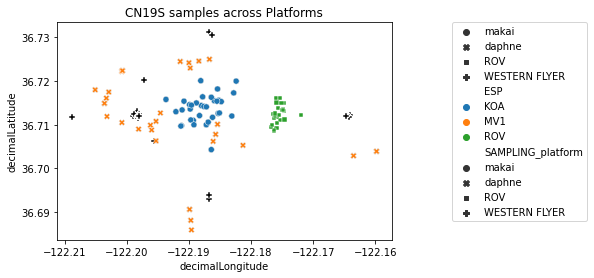

Number of samples: 312
['FilterID', 'target_gene', 'PlateID', 'library', 'local_time', 'time_label', 'SAMPLING_cruise', 'depth', 'SAMPLING_platform', 'SC', 'ESP', 'SAMPLING_station_number', 'SAMPLING_station', 'SAMPLING_bottle', 'decimalLongitude', 'decimalLatitude', 'sample_type', 'Plates', 'Markers', 'Status', 'Dewar_name', 'Sampling_method', 'replicate', 'SAMPLING_rdepth', 'project_name', 'nitrate', 'fluor', 'density', 'pressure', 'minimumDepthInMeters', 'maximumDepthInMeters', 'start_GMT', 'end_GMT', 'temp', 'salinity', 'sigmat', 'spice', 'diss_oxygen', 'PAR (umol/s/m2)', 'altitude', 'chlorophyll', 'bbp470 (count)', 'bbp650 (count)', 'SAMPLING_project', 'ESP_name', 'diel', 'month', 'day', 'hour', 'eventDate', 'depth_rov', 'latitude', 'longitude', 'ROVtime', 'ROVday']


,FilterID,target_gene,PlateID,library,local_time,time_label,SAMPLING_cruise,depth,SAMPLING_platform,SC,...,diel,month,day,hour,eventDate,depth_rov,latitude,longitude,ROVtime,ROVday
sample_name,,,,,,,,,,,,,,,,,,,,,
20191022_EB_JJ,20191022_EB,12S,JJ,JJ94,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
20191203_EB_RR,20191203_EB,12S,RR,RR95,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
ArtComm1_RR,ArtComm1,12S,RR,RR94,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
ArtComm1_BK,ArtComm1,12S,BK,BK92,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
ArtComm2_BK,ArtComm2,12S,BK,BK93,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pcrblank3_RR,pcrblank3,12S,RR,RR96,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
pcrblank3_BK,pcrblank3,12S,BK,BK91,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
pcrblank_1_JJ,pcrblank_1,12S,JJ,JJ32,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [40]:
# USE CN19 specific metadata
file = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/metadata/CN19all_CTD_ESP_sequenced_metadata_050321_annotated.csv'

df = pd.read_csv(file)
#df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('FilterID', inplace=True)
CN19_meta = df.copy()
df.head()
df = meta_all.copy()
#print(list(df))
cols = ['FilterID','SAMPLING_cruise','SAMPLING_station_number','SAMPLING_bottle','sample_type', 'SAMPLING_platform','ESP', 'SC', 'PlateID', 'target_gene']
df['target_gene'] = marker
df['FilterID'] = df.index.str.split('_').str[:-1]
df['FilterID'] = df['FilterID'].str.join('_')

#make sure match current standards:
#fix no single digit CTD bottle numbers
for i in range(1,10):
    #print(i)
    z = str(i)
    df['FilterID'] = df['FilterID'].str.replace('_'+z+'_','_0'+z+'_' )

#fix ESP names
df['FilterID'] = df['FilterID'].str.replace('koa|Koa','KOA')

#fix bongo names
df['FilterID'] = df['FilterID'].str.replace('Bongo|BONGO', 'bongo')
df['FilterID'] = df['FilterID'].str.replace('_bongo', 'bongo')
df['FilterID'] = df['FilterID'].str.replace('bongo', '_bongo')


print(df['SAMPLING_cruise'].unique())

#Just the right libraries:
print(libs)
df = df.loc[df['PlateID'].isin(libs)==True]

# REMOVE THESE LIBRARIES, SPECIFIED AT TOP
df = df.loc[df['PlateID'].isin(drop_libs)==False]

#Get the control samples:
print('sample_types:',df['sample_type'].unique())
controls = df.loc[df['sample_type'].isin(['environmental'])==False]
controls = controls.loc[controls['SAMPLING_cruise']!='CN19S']  #ESP samples that might not be marked as controls

#Just CN19S samples
df = df.loc[df.index.str.contains('CN19S')==True]
df = df.loc[df.index.str.contains('OSU_EB')==False]
#Not C1, M1, M2
df = df.loc[df['SAMPLING_station'].isin(['C1', 'MOORING1', 'MOORING2'])==False]

#remove Bongo samples
df = df.loc[df['FilterID'].str.contains('Bongo|bongo')==False]


#df = df.loc[df['SAMPLING_cruise'].str.contains('CN19S|CN19F')==True]
print(df['SAMPLING_cruise'].unique())

#df = df[cols]
df = df[['FilterID', 'target_gene', 'PlateID', 'library']]
df = df.join(CN19_meta, on='FilterID')

#check for unmerged samples:
#df = df.loc[df['SAMPLING_cruise'].isna()==True]

#now need to add back in all control samples from plates.

df= pd.concat([df, controls[['sample_type', 'SC', 'ESP', 'PlateID', 'target_gene', 'FilterID', 'library']]], axis=0)

# time label convert to datetime object
df['local_time'] = pd.to_datetime(df['local_time'])

# Remove ROV samples
#df = df.loc[df['Sampling_method']=='ROV']
#df = df.loc[df['FilterID'].str.contains('V4195')==False]

#Remove AT and BJ libraries as duplicates
df = df.loc[df['PlateID'].isin(['AT', 'BJ'])==False]

#label duplicate filters:
# df['DUP'] = df['FilterID'].duplicated(keep=False)

# remove drift samples at end of deployment:
df = df.loc[(df['ESP']=='MV1')&(df['SC']<=19)==False]

# remove ESP sample with no environmental data:
df = df.loc[df['FilterID']!='CN19SESPMV1_SC57_eDNA']
df = df.sort_values('local_time')


## Join with ROV_meta
df = df.reset_index().set_index('FilterID')
#df = pd.concat([df, ROV_meta], axis=0)
df = df.join(ROV_meta, rsuffix='_rov')
'''
#check for duplicate samples
test = df.copy()
test['DUP'] = test.duplicated('sample_name',keep=False)
print(test.loc[test['DUP']==True])'''

df = df.reset_index().set_index('sample_name')
df = df.rename(columns={'index':'FilterID'})
df.loc[df['depth'].isna(), 'depth'] = df['depth_rov']
# 'latitude', 'longitude'
#'decimalLongitude', 'decimalLatitude'
df.loc[df['decimalLongitude'].isna(), 'decimalLongitude'] = df['longitude']
df.loc[df['decimalLatitude'].isna(), 'decimalLatitude'] = df['latitude']

df.loc[df['Sampling_method']=='ROV', 'SAMPLING_platform'] = 'ROV'

# Fix ROV times - need to figure out from VARS, for now approximate  ##### FIX ########
# Dive V4195 started at 10:07 to 14:22 (local); 17 to 21:22 GMT
# Dive V4196 started at 10:53 to 15:08 (local); 17 to 22 GMT
#df['ROVtime'] = pd.to_datetime(df['ROVtime'])
df['ROVday'] = pd.to_datetime(df['ROVday'])
df = df.reset_index()
df.loc[df['sample_name'].str.contains('V4195'), 'local_time'] = pd.to_datetime('06/03/2019 12:00:00')
df.loc[df['sample_name'].str.contains('V4195'), 'time_label'] = '06-03 day'
df.loc[df['sample_name'].str.contains('V4195'), 'ESP'] = 'ROV'
df.loc[df['sample_name'].str.contains('V4195'), 'diel'] = 'day'

df.loc[df['sample_name'].str.contains('V4196'), 'local_time'] = pd.to_datetime('06/04/2019 12:00:00')
df.loc[df['sample_name'].str.contains('V4196'), 'time_label'] = '06-04 day'
df.loc[df['sample_name'].str.contains('V4196'), 'ESP'] = 'ROV'
df.loc[df['sample_name'].str.contains('V4196'), 'diel'] = 'day'
df = df.set_index('sample_name')

# Plot samples:
#df = df.loc[df['Sampling_method']=='ESP']
#df = df.loc[df['sample_type']=='environmental']
df['decimalLatitude'] = df['decimalLatitude'].astype(float)
df['decimalLatitude'] = df['decimalLatitude'].round(4)
df['decimalLongitude'] = df['decimalLongitude'].round(4)


import seaborn as sns
sns.scatterplot(data=df,x='decimalLongitude', y='decimalLatitude',style='SAMPLING_platform', color='k')

sns.scatterplot(data=df,x='decimalLongitude', y='decimalLatitude', hue='ESP', style='SAMPLING_platform')
plt.legend(bbox_to_anchor=(1.18, 1), loc=2, borderaxespad=0.,ncol=1, fontsize='10')


plt.title('CN19S samples across Platforms')

filename=plot_dir +'sample_map_CN19S_byplatform.pdf'
print(filename)
plt.savefig(filename,dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format=None,
        transparent=True, bbox_inches='tight', pad_inches=1,
        frameon=None)


plt.show()
print('Number of samples:', len(df.index))

#look it over
df.to_csv('/Users/kpitz/Documents/test.csv')

meta_project = df.copy()
meta_project.head()

print(list(df))
df

### Limit ASV table, Taxa table by new metadata file:

In [41]:
otu_project, taxa_project = from_metadata_to_taxareads(meta_project, otu_all, taxa_all)

# Limit sequences to just those in otu table
df = pd.concat([seq_all, otu_project], join='inner', axis=1)
df = df[['sequence']]
seq_project = df.copy()

# EXPORT FOR ANALYSIS
#export to csv files
folder = '/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/'
dfs = [otu_project, taxa_project, seq_project, meta_project]
names = ['otu', 'taxa', 'seq', 'meta']
for df, name in zip(dfs,names):
    df.to_csv(folder + 'CN19S_'+marker+'_Dada2_'+name+'_merged.csv')
    print(folder + 'CN19S_'+marker+'_Dada2_'+name+'_merged.csv')
    

/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_otu_merged.csv
/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_taxa_merged.csv
/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_seq_merged.csv
/Users/kpitz/github/MBARI-BOG/CN19S_12S/data/Dada2_seq_data/CN19S_12S_Dada2_meta_merged.csv
